# Preprocessing

## Structure of the code
1. Combine header and text column
2. Anonymisation
    - Remove names
    - Remove dates
    - Create unique ids for each person
    - Use review and url to remove repeated comments
    - Remove urls
3. Cleaning and processing
    - If a comment was only punctuation => remove that row
4. Balance data (around 17,000 per category)
    - Randomise data (in categories)
    - Keep the first 17,000 of each category

## Initial code

In [115]:
#!pip install numpy pandas seaborn

In [116]:
# system tools
import os
import sys
import random
import requests as req
import re

# data wranling
import pandas as pd
import numpy as np
import matplotlib as mpl

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
# TrustPilot colors for plotting
colors = ['#ff3722','#ff8623','#ffce00','#72cf10','#00b67a']

In [118]:
# define path
path = os.path.join("..", "in", "postnord_trustpilot_reviews.csv")

In [119]:
# read csv
df = pd.read_csv(path)
# fill empty columns with white space
df.fillna(" ", inplace = True)
# rename columns
df.columns = ['order', 'name', 'date', 'rating', 'text', 'profile_link', 'review_count', 'header']

In [120]:
print(f"Beginning # of rows {len(df)}")

Beginning # of rows 399980


## Combination of header and text column

In [121]:
# remove dots from the end of the header
df['header'] = df['header'].str.replace('…', '', regex = False)

In [122]:
# create a list
review = []

# loop over the dataframe
for index, row in df.iterrows():
    # txt is the text-column
    txt = row["text"]
    # head is the header-column
    head = row["header"]
    # search for the header text in the text-column
    x = re.search(f"^{re.escape(head)}", txt)
    # if the header text occurs in the text-column
    if x:
        # append the text column to the list
        review.append(row['text'])
    # otherwise...
    else:
        # append the header column and the text column to the list with a white space in between
        review.append(row['header'] + " " + row['text'])

In [123]:
# create a new review-column from the list
df['review'] = review

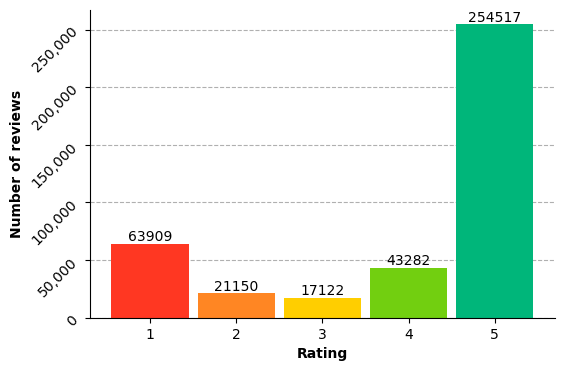

In [124]:
# place gridlines below elements in plots
plt.rc('axes', axisbelow=True)

# plot data distribution
fig, ax = plt.subplots(figsize = (6,4))
ax = df.groupby('rating').review.count().plot.bar(
    ylim=0, color=colors, width= 0.9)
# add bar labels
for i, v in enumerate(df.groupby('rating').review.count()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.ylabel('Number of reviews', fontsize = 10, weight = "bold")
plt.xlabel('Rating', fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--') # add a grid
ax.spines[['right', 'top']].set_visible(False) # remove top and right spine
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # 1000 -> 1,000
plt.xticks(rotation='horizontal')
plt.yticks(rotation=45)
plt.show()

## Removal of duplicates

In [125]:
# drop any duplicates
df = df.drop_duplicates(subset=['profile_link', 'date', 'review'], keep='first')

In [126]:
print(f"# rows after removing duplicates: {len(df)}")

# rows after removing duplicates: 399537


## Anonymisation

In [127]:
# drop any columns with 'personfølsom data'
df = df.drop(columns=['name', 'date', 'profile_link', 'header', 'text', 'order', 'review_count'])

## Cleaning and processing

In [128]:
clean_review = []

for text in df['review'].tolist():
    # remove punctuation
    text = re.sub('[^\w\s]+', '', text)
    # remove double white spaces
    text = re.sub(' +', ' ', text)
    # remove white space at beginning and end of line
    text = text.strip()
    # make text lower
    text = text.lower()
    # append to list
    clean_review.append(text)

# add clean data to dataframe
df['review'] = clean_review

In [129]:
# add NaN to empty cells
df['review'].replace('', np.nan, inplace=True)
# remove all cells with NaN
df.dropna(subset=['review'], inplace=True)
print("# rows after removing empty rows:", len(df))

# rows after removing empty rows: 398866


## Removal of stopwords

In [130]:
# get Danish stopwords
url = "https://gist.githubusercontent.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b/raw/fa34ef448aff6adbb4b6bab9bda62a8b0f1ee597/stopord.txt"
res = req.get(url)
# create TXT file for stopwords
txt_path = os.path.join("..", "in", "stopwords.txt")
# open empty TXT
file = open(txt_path, "w")
# write stopwords to TXT
file.write(res.text)
# close 'write' mode
file.close()

In [131]:
# read stopwords TXT
with open(txt_path) as f:
    # get lines
    lines = f.readlines()
f.close()

In [132]:
# create list of stopwords
stopwords = []
for l in lines:
    # remove \n at the end of each line
    stopwords.append(l.strip())

In [133]:
# remove stopwords from data
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [134]:
# remove empty lines (again)
df['review'].replace('', np.nan, inplace=True)
df.dropna(subset=['review'], inplace=True)
print("# rows after removing empty rows (again):", len(df))

# rows after removing empty rows (again): 397199


## Lengths

In [135]:
# get length of review
df["length"] = df.review.str.len()
# get mean lengths per rating
mean_lengths = df.groupby(by = 'rating').mean('length')
# add rating as a column
mean_lengths['rating'] = mean_lengths.index

In [136]:
# get values for plot
height = [l for l in mean_lengths['length']]
bars = [r for r in mean_lengths['rating']]
labels = [round(l, 1) for l in mean_lengths['length']]

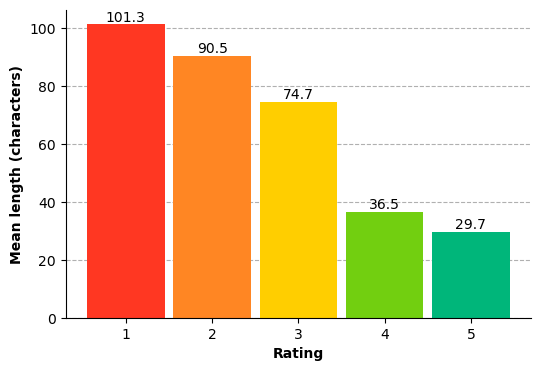

In [137]:
# plot mean lengths
fig, ax = plt.subplots(figsize = (6,4))

ax.bar(bars, height, align='center', color = colors, width = 0.9)
ax.set_xlabel('Rating', fontsize = 10, weight = "bold")
ax.set_ylabel('Mean length (characters)', fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--')
for i in range(len(bars)):
    plt.text(bars[i], height[i], str(labels[i]), ha='center', va='bottom')
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [138]:
# show texts that will be removed
print(df.loc[np.array(list(map(len,df.review.values)))<((int(mean_lengths['length'].min()))-14)])

# remove texts shorter than the lowest mean length -15
df = df.loc[np.array(list(map(len,df.review.values)))>((int(mean_lengths['length'].min()))-15)]

        rating          review  length
1            5    pakker tiden      12
6            4   gik forventet      13
10           5      sædvanligt      10
17           5         hurtigt       7
22           5      lynhurtigt      10
...        ...             ...     ...
399939       4  kekdkfkfkfkkkd      14
399948       1        langsomt       8
399956       5   hurtig venlig      13
399972       5         udsætte       7
399973       4  fungerede fint      14

[65095 rows x 3 columns]


In [139]:
print("# rows after removing short reviews:", len(df))

# rows after removing short reviews: 332104


In [140]:
# reset index after removing lines
df = df.reset_index(drop=True)

In [141]:
# show 
df.sort_values("length")

,rating,review,length
0,5,hurtig levering,15
119553,5,hurtig levering,15
119577,5,hurtig levering,15
119580,5,hurtig levering,15
119592,5,track and trace,15
...,...,...,...
25379,1,advarsel dato levering post nord sms d 48 modt...,1383
129394,1,give minus 5 stjerner give minus 5 stjerner va...,1485
222256,1,postnord trænger kundeservice egentligt postno...,1498
79176,1,glemt pakke dovenskab gennemgang mails stykke ...,1658


In [142]:
print(f"Shortest review: {df['length'].min()}")
print(f"Longest review:  {df['length'].max()}")

Shortest review: 15
Longest review:  1724


## Balancing the data

In [143]:
# print distribution of data before balancing
df['rating'].value_counts()

5    200651
1     60823
4     34452
2     20287
3     15891
Name: rating, dtype: int64

In [144]:
# balancing function
def balance(dataframe, random_state = 42): # take a dataframe and a random state as input
    # Use pandas select a random bunch of examples from each label
    out = (dataframe.groupby('rating', as_index=False)
            .apply(lambda x: x.sample(dataframe['rating'].value_counts().min(), random_state = random_state))
            .reset_index(drop=True))
    # take a random sample of each label
    return out

In [145]:
# balance the data
df = balance(df, random_state = 42)
# print distribution of data after balancing
df['rating'].value_counts()

1    15891
2    15891
3    15891
4    15891
5    15891
Name: rating, dtype: int64

In [146]:
# make sure the ratings are parsed as strings not integers!
df['rating'] = df['rating'].astype(str)
# reset the index
df = df.reset_index(drop=True)

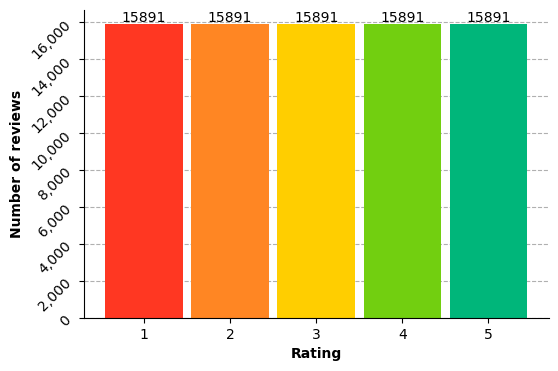

In [147]:
# plot the new distribution of data
fig, ax = plt.subplots(figsize=(6,4))

ax = df.groupby('rating').review.count().plot.bar(
    ylim=0, color=colors, width= 0.9)
for i, v in enumerate(df.groupby('rating').review.count()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.ylabel('Number of reviews', fontsize = 10, weight = "bold")
plt.xlabel('Rating', fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation='horizontal')
plt.yticks(rotation=45)
plt.show()

In [148]:
# create a path for saving the cleaned dataframe
balancepath = os.path.join("..", "in", "balanced_dataset.csv")
# save the CSV
df.to_csv(balancepath, index = False)